In [1]:
# 相关库导入
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
plt.rcParams['font.sans-serif']=['SimHei']  # 防止中文出现乱码
plt.rcParams['axes.unicode_minus'] = False  # 防止中文出现乱码

In [48]:
# 图像导入
#img = cv2.imread('Images/lena.jpeg',1)
#img = cv2.imread('Images/girl.jpeg',1)
#img = cv2.imread('Images/woman2.png',1)
#img = cv2.imread('Images/cameraman.jpg',1)
#img = cv2.imread('Images/girl4.jpg',1)
#img = cv2.imread('Images/beauty.jpg',1)     # 终极素材
#img = cv2.imread('Images/QUT2.jpg')
img = cv2.imread('Images/mopi.jpeg',1)
#img = cv2.imread('Images/QingDao1.jpg',1)
#img = cv2.imread('Images/Sunshine_girl3.jpg',1)
imgInfo = img.shape
height = imgInfo[0]
width = imgInfo[1]
cv2.imshow('Image',img)
cv2.waitKey(0)
cv2.destroyAllWindows()
# 

In [ ]:
# Gray World 色彩均衡 效果一般
def Gray_World(dst):
    height = dst.shape[0]
    width = dst.shape[1]
    sumR = 0
    sumG = 0
    sumB = 0
    max = 0
    for i in range(0,height):
        for j in range(0,width):
            sumR = sumR + dst[i,j,2]
            sumG = sumG + dst[i,j,1]
            sumB = sumB + dst[i,j,0]              
    avgR = sumR/(height*width)
    avgG = sumG/(height*width)
    avgB = sumB/(height*width)
    print(avgR,avgG,avgB)
    avgGray = (avgR+avgG+avgB)/3
    ar = avgGray/avgR
    ag = avgGray/avgG
    ab = avgGray/avgB
    for i in range(0,height):
        for j in range(0,width):
            dst[i,j,2] = int(dst[i,j,2]*ar)         # 对于图像中每个像素dst[i,j] 调整其R、G、B分量 new Ｒ　＝　old Ｒ ＊ ａｒ
            dst[i,j,1] = int(dst[i,j,1]*ag)
            dst[i,j,0] = int(dst[i,j,0]*ab)
            if(dst[i,j,2]>max):                     # max为RGB三个分量中的最大值
                max = dst[i,j,2]
            if(dst[i,j,1]>max):
                max = dst[i,j,1]
            if(dst[i,j,0]>max):
                max = dst[i,j,0]
    factor = max/255                                 # 归一化处理
    print(factor)
    if(factor>1):
        for i in range(0,height):
            for j in range(0,width):
                dst[i,j,2] = int(dst[i,j,2]/factor)
                dst[i,j,1] = int(dst[i,j,1]/factor)
                dst[i,j,0] = int(dst[i,j,0]/factor)
    cv2.imshow('dst',dst)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return dst
dst1 = Gray_World(img)

In [ ]:
# 参考白算法 知乎找的，没找到源文献
def reference_white(img):
    img_shape = img.shape
    img_b = img[:,:,0].astype('float')
    img_g = img[:,:,1].astype('float')
    img_r = img[:,:,2].astype('float')
    
    img_ycbcr = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    img_y = img_ycbcr[:,:,0]
    img_y_sort = np.sort(img_y.reshape( -1))
    num = int(img_y_sort.shape[0] * 0.03)
    T1 = img_y_sort[-num]
    T2 = img_y_sort[num]
    
    n1 = 0
    n2 = 0
    img_r_big_sum = 0
    img_g_big_sum = 0
    img_b_big_sum = 0
    img_r_small_sum = 0
    img_g_small_sum = 0
    img_b_small_sum = 0
    
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            if img_y[i, j] >= T1:
                img_r_big_sum =+ img_r[i,j]
                img_g_big_sum =+ img_g[i,j]
                img_b_big_sum =+ img_b[i,j]
                n1 =+ 1

            if img_y[i, j] <= T2:
                img_r_small_sum = + img_r[i, j]
                img_g_small_sum = + img_g[i, j]
                img_b_small_sum = + img_b[i, j]
                n2 =+ 1
    
    r_mean1 = img_r_big_sum/n1
    g_mean1 = img_g_big_sum/n1
    b_mean1 = img_b_big_sum/n1
    
    r_mean2 = img_r_small_sum/n2
    g_mean2 = img_g_small_sum/n2
    b_mean2 = img_b_small_sum/n2

    gama_r = -1
    gama_g = -1
    gama_b = -1
    
    print(r_mean2, r_mean1)
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            img_r[i,j] = (img_r[i,j] - r_mean2)/(r_mean2 - r_mean1)*gama_r
            img_g[i,j] = (img_g[i,j] - g_mean2)/(g_mean2 - g_mean1)*gama_g
            img_b[i,j] = (img_b[i,j] - b_mean2)/(b_mean2 - b_mean1)*gama_b
            
    img_new = np.zeros(shape=[img_shape[0], img_shape[1], 3])
    img_new[:,:,0] = img_b
    img_new[:,:,1] = img_g
    img_new[:,:,2] = img_r

    img_new = np.minimum(img_new, 1)
    img_new = np.maximum(img_new,0)
    img_new = np.uint8(img_new*255)
    cv2.imshow('img',img)
    cv2.imshow('img_new',img_new)
    cv2.waitKey()
    cv2.destroyAllWindows()
    return img_new

img_white = reference_white(img)

In [3]:
# RGB<=> HSI
def RGB2HSI(img):
    IMG = img/255.0                                               # 首先进行归一化处理
    R = IMG[:,:,2]
    G = IMG[:,:,1]
    B = IMG[:,:,0]
    height = img.shape[0]
    width = img.shape[1]       
    H = np.zeros((height,width),dtype=np.float16)                 # 定义H通道
    S = np.zeros((height,width),dtype=np.float16)
    I = np.zeros((height,width),dtype=np.float16)
    I = (R+G+B)/3.0                   # 求出I值（亮度）
    for i in range (0,height):
        for j in range(0,width):
            den = np.sqrt((R[i,j]-G[i,j])**2+ (R[i,j] - B[i,j]) * (G[i,j] - B[i,j]))                    # 定义计算theta中的分母
            if den<=0:
                theta = 0
            else:
                theta = np.arccos(0.5*(2*R[i,j]-G[i,j]-B[i,j])/den)
            if(B[i,j]<=G[i,j]):
                H[i,j] = theta
            else:
                H[i,j] = 2*np.pi - theta
            arr = [R[i,j],G[i,j],B[i,j]]
            min_num = np.min(arr)
            H[i,j] = H[i,j]/(2*np.pi)              
            S[i,j] = 1 - min_num/I[i,j]
    HSI = np.zeros((height,width,3),dtype=np.uint8)   
    HSI[:, :, 0] = H * 255
    HSI[:, :, 1] = S * 255
    HSI[:, :, 2] = I * 255
    return HSI

HSI = RGB2HSI(img)

C:\Users\Yehui_PC\AppData\Local\Temp\ipykernel_2440\4220437859.py:27: RuntimeWarning: invalid value encountered in scalar divide
  S[i,j] = 1 - min_num/I[i,j]
C:\Users\Yehui_PC\AppData\Local\Temp\ipykernel_2440\4220437859.py:19: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(0.5*(2*R[i,j]-G[i,j]-B[i,j])/den)
C:\Users\Yehui_PC\AppData\Local\Temp\ipykernel_2440\4220437859.py:29: RuntimeWarning: invalid value encountered in cast
  HSI[:, :, 0] = H * 255
C:\Users\Yehui_PC\AppData\Local\Temp\ipykernel_2440\4220437859.py:30: RuntimeWarning: invalid value encountered in cast
  HSI[:, :, 1] = S * 255


In [ ]:
def HSI2RGB(hsi_img):
   """
   这是将HSI图像转化为RGB图像的函数
   :param hsi_img: HSI彩色图像
   :return: RGB图像
   """
   # 保存原始图像的行列数
   row = np.shape(hsi_img)[0]
   col = np.shape(hsi_img)[1]
   # 对原始图像进行复制
   rgb_img = hsi_img.copy()
   # 对图像进行通道拆分
   H, S, I = cv2.split(hsi_img)
   # 把通道归一化到[0,1]
   [H, S, I] = [i / 255.0 for i in ([H, S, I])]
   R, G, B = H, S, I
   for i in range(row):
       h = H[i] * 2 * np.pi
       # H大于等于0小于120度时
       a1 = h >= 0
       a2 = h < 2 * np.pi / 3
       a = a1 & a2  # 第一种情况的花式索引
       tmp = np.cos(np.pi / 3 - h)
       b = I[i] * (1 - S[i])
       r = I[i] * (1 + S[i] * np.cos(h) / tmp)
       g = 3 * I[i] - r - b
       B[i][a] = b[a]
       R[i][a] = r[a]
       G[i][a] = g[a]
       # H大于等于120度小于240度
       a1 = h >= 2 * np.pi / 3
       a2 = h < 4 * np.pi / 3
       a = a1 & a2  # 第二种情况的花式索引
       tmp = np.cos(np.pi - h)
       r = I[i] * (1 - S[i])
       g = I[i] * (1 + S[i] * np.cos(h - 2 * np.pi / 3) / tmp)
       b = 3 * I[i] - r - g
       R[i][a] = r[a]
       G[i][a] = g[a]
       B[i][a] = b[a]
       # H大于等于240度小于360度
       a1 = h >= 4 * np.pi / 3
       a2 = h < 2 * np.pi
       a = a1 & a2  # 第三种情况的花式索引
       tmp = np.cos(5 * np.pi / 3 - h)
       g = I[i] * (1 - S[i])
       b = I[i] * (1 + S[i] * np.cos(h - 4 * np.pi / 3) / tmp)
       r = 3 * I[i] - g - b
       B[i][a] = b[a]
       G[i][a] = g[a]
       R[i][a] = r[a]
   rgb_img[:, :, 0] = B * 255
   rgb_img[:, :, 1] = G * 255
   rgb_img[:, :, 2] = R * 255
   return rgb_img



In [4]:
# 伽马校正
def Gamma_correction(img,gamma):
    dst = np.array(255 * (img / 255) ** gamma, dtype='uint8')           # 先归一化处理， 再进行非线性变换，最后再映射到[0,255]
    # cv2.imshow('src',img)
    # cv2.imshow('dst',dst)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return dst

#Gamma_correction(img,0.9)



In [ ]:
# 直方图均衡化 适用于灰度图像
#def Hist_equalization_Grey(img):
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
equ = cv2.equalizeHist(gray)
cv2.imshow('src',img)
cv2.imshow('equ',equ)

plt.hist(img.ravel(),256,[0,256],label='原图')
plt.figure
plt.hist(equ.ravel(),256,[0,256],label = '均衡化后')
plt.xlabel('灰度值')
plt.ylabel('频数')
plt.legend(loc='upper right')
plt.show()
cv2.waitKey(0)
cv2.destroyAllWindows()

#Hist_equalization_Grey(img)

In [ ]:
# 局部直方图均衡化
# 思路： 将原图分成若干个小块，对每个小块进行直方图均衡化，然后将均衡化后的图像合并起来
# 这种方法主要对于图像直方图不是那么单一的（比如存在多峰情况）图像比较实用
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(300,300))
result = clahe.apply(gray)

#显示图像
plt.subplot(221)
plt.imshow(gray, cmap=plt.cm.gray), plt.axis("off"), plt.title('（a）') 
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.3)       # wspace调整子图的间距
plt.subplot(222)
plt.imshow(equ, cmap=plt.cm.gray), plt.axis("off"), plt.title('（b）') 
plt.subplot(223)
plt.hist(img.ravel(), 256)
plt.title('（c）') 
plt.xlabel('灰度值')
plt.ylabel('频数')
plt.subplot(224)
plt.hist(equ.ravel(), 256,color='#ff7f0e')
plt.title('（d）')
plt.xlabel('灰度值')
plt.ylabel('频数')
plt.show()
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# 直方图均衡化对比
equ = cv2.equalizeHist(gray)
plt.hist(equ.ravel(),256,[0,256],label="直方图均衡化")
plt.hist(result.ravel(), 256,label="局部直方图均衡化")
plt.xlabel('灰度值')
plt.ylabel('频数')
plt.legend(loc='upper right')       # 添加图例
#plt.title("直方图均衡化对比")
plt.show()

In [ ]:
# 直方图均衡化 适用于彩色图像 
# 思路1：步骤分别对BGR三个通道进行直方图均衡化，然后合并即可
# 思路2：将其分离成HSI空间，其中I是亮度，单独对亮度进行均衡化即可
#图形美化设置

from matplotlib.ticker import FuncFormatter
# 科学计数法形式函数
def formatnum(x, pos):
    return '%.2f×10$^{5}$' % (x/1e5)

def Hist_equalization_RGB(img):
    R = img[:,:,2]
    G = img[:,:,1]
    B = img[:,:,0]
    R_equ = cv2.equalizeHist(R)                 # 均衡化
    G_equ = cv2.equalizeHist(G)         
    B_equ = cv2.equalizeHist(B)
    img_equ = cv2.merge([B_equ,G_equ,R_equ])    # 合并　
    # 显示图像
    plt.figure(0)
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.title("原图像")
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(img_equ,cv2.COLOR_BGR2RGB))
    plt.title("对RGB色彩均衡化处理后")

    # cv2.namedWindow('src', cv2.WINDOW_NORMAL)
    # cv2.resizeWindow('src', 1600, 900)
    # cv2.imshow('src',img)
    # cv2.namedWindow('equ', cv2.WINDOW_NORMAL)
    # cv2.resizeWindow('equ', 1600, 900)
    # cv2.imshow('equ',img_equ)                   

    # 以下为直方图绘制代码
    plt.figure(1)

    plt.subplot(2,1,1)
    plt.xlim(0,256)                             # 限制x坐标轴的范围
    plt.hist(R.ravel(),256,[0,256],label='原R分量灰度直方图',color='red')
    plt.xlabel('灰度值')
    plt.ylabel('频数')
    formatter = FuncFormatter(formatnum)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.legend(loc='upper right')       # 添加图例
    # ax = plt.gca()        # 1e3 形式
    # ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
    # ax.get_yaxis().get_offset_text().set(va='bottom', ha='left')
    # ax.yaxis.get_offset_text().set_fontsize(16)#设置1e6的大小与位置

    plt.subplot(2,1,2)
    plt.hist(R_equ.ravel(),256,[0,256],label='均衡化后直方图',color='OrangeRed')
    plt.xlim(0,256)                             # 限制x坐标轴的范围
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.3)       # wspace调整子图的间距
    formatter = FuncFormatter(formatnum)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.xlabel('灰度值')
    plt.ylabel('频数')
    plt.legend(loc='upper right')       # 添加图例
    #plt.yticks(np.linspace(0,4e3,5),fontsize=10)
    #plt.suptitle("R分量直方图均衡化结果图")
    plt.show()
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return img_equ

#img_equ_RGB = Hist_equalization_RGB(img)

def Hist_equalization_HSI(img):
    HSI_img = RGB2HSI(img)
    H = HSI_img[:,:,0]
    S = HSI_img[:,:,1]
    I = HSI_img[:,:,2]
    I_equ = cv2.equalizeHist(I)
    # clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(2,2))
    # I_equ = clahe.apply(I)

    plt.figure(2)
    plt.hist(I.ravel(),256,[0,256],label='原I分量灰度直方图',color='red')
    plt.hist(I_equ.ravel(),256,[0,256],label='处理后直方图',color='orange')
    
    equ = cv2.merge([H,S,I_equ])
    cv2.namedWindow('src', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('src', 1600, 900)
    cv2.imshow('src',img)
    cv2.namedWindow('equ', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('equ', 1600, 900)
    cv2.imshow('equ',HSI2RGB(equ))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

#Hist_equalization_HSI(img)


In [5]:
# HSV 直方图均衡化
def Hist_equalization_HSV(img):
    HSI_img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    H = HSI_img[:,:,0]
    S = HSI_img[:,:,1]
    V = HSI_img[:,:,2]
    #V_equ = cv2.equalizeHist(V)
    S_equ = Gamma_correction(S,0.8)
    clahe = cv2.createCLAHE(clipLimit=1.3, tileGridSize=(8,8))
    V_equ = clahe.apply(V) 

    equ2 = cv2.merge([H,S_equ,V_equ])
    equ1 = cv2.merge([H,S,V_equ])
    dst1 = cv2.cvtColor(equ1,cv2.COLOR_HSV2BGR)
    dst2 = cv2.cvtColor(equ2,cv2.COLOR_HSV2BGR)

    # cv2.imshow('src',img)
    # cv2.imshow('equ1',dst1)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return dst1


In [ ]:
img_equ_HSV = Hist_equalization_HSV(img)[0]
img_equ_HSV_Gamma = Hist_equalization_HSV(img)[1]
#cv2.imwrite("HSV.png",img_equ_HSV)
# 作图代码
plt.figure(0)
plt.subplot(131)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("原图")
plt.subplot(132)
plt.imshow(cv2.cvtColor(img_equ_HSV,cv2.COLOR_BGR2RGB))
plt.title("HSV均衡化")
plt.axis('off')
plt.subplot(133)
plt.imshow(cv2.cvtColor(img_equ_HSV_Gamma,cv2.COLOR_BGR2RGB))
plt.title("结合伽马校正的HSV均衡化")
plt.axis('off')

In [ ]:
# 合工大的一种基于亮度均衡的图像阈值分割技术
ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
height = img.shape[0]
width = img.shape[1]
I = ycrcb[:,:,0]
mean_I = int(np.sum(I)/(height*width))
I_matrix = np.zeros((height/mean_I,width/mean_I))
size = 16                                       # 取定一个方块的大小为16X16
for i in range(0,height-size):
    for j in range(0,width-size):
        I_block = I[i:i+size,j:j+size]

In [6]:
# 结合蚁群算法的改进OSTU多阈值算法
np.seterr(invalid='ignore') #之所以加这一句是因为下面除法的时候会除零报错
import random
import numpy as np
def normalize_probabilities(probabilities):
    total = np.sum(probabilities)
    if total == 0:
        # 如果总和为零，返回均匀分布
        return np.ones_like(probabilities) / len(probabilities)
    normalized = probabilities / total
    # 将任何 NaN 值替换为均匀分布值
    normalized = np.where(np.isnan(normalized), 1.0 / len(probabilities), normalized)
    return normalized

def Fitness_Function(img,th1,th2):
    k1 = th1
    k2 = th2
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pixels = cv2.calcHist([img], [0], None, [256], [0, 256])                # 计算每个灰度级中所含像素数，返回的是一个（256,1）的数组
    p = pixels / (img.shape[0] * img.shape[1])                              # 获得每个灰度级中像素数占总像素数比例则我们获得了p_i的一个向量
    x=np.linspace(1,256,256)                                                # 灰度级像素范围定义，若定义为0～255，则求平均灰度级时会忽略第一个数据，所以我们定义为从1到256                                                 
    maxvar = 0                                                              # 最大类间类内方差
    mu_T = np.sum(x*p)                                                      # 平均灰度级
    step = 0
    a0 = np.sum(p[0:k1])
    a1 = np.sum(p[k1:k2])
    a2 = 1-a0-a1
    if(a0==0):
        r1 = 0
    else:
        mu_0 = np.dot(x[0:k1],p[0:k1])/a0
        r1 = a0*(mu_0-mu_T)**2
    if(a1==0):
        r2 = 0
    else:
        mu_1 = np.dot(x[k1:k2],p[k1:k2])/a1
        r2 = a1*(mu_1-mu_T)**2
    if(a2==0):
        r3 = 0
    else:
        mu_2 = np.dot(x[k2:256],p[k2:256])/a2
        r3 = a2*(mu_2-mu_T)**2
    sigma_b = r1+r2+r3
    m1 = np.dot(x[0:k1],p[0:k1])/a0
    m2 = np.dot(x[k1:k2],p[k1:k2])/a1
    m3 = np.dot(x[k2:256],p[k2:256])/a2
    sigma_in = np.sum(p[0:k1]*(x[0:k1]-m1)**2)+np.sum(p[k1:k2]*(x[k1:k2]-m2)**2) +np.sum(p[k2:256]*(x[k2:256]-m3)**2)
    vars = sigma_b/sigma_in
    return vars

def OTSU_MULTY_IMPROVE_ACO(img):
    num_ants=10                 # 蚂蚁数量
    max_iter=10               # 最大迭代次数
    alpha=2                   # 信息素重要性因子
    rho=0.2                     # 信息素挥发系数
    Q= 4                       # 信息素强度常数  
    pheromone = np.ones([256,2])    # 初始化信息素                                            # 初始化每个灰度值的信息素都为1
    best_threshold = 0
    best_maxvar = 0
    ants = np.zeros((num_ants,2), dtype=int)
    threshold_prob = np.ones([256,2])/256

    for iteration in range(max_iter):
        for i in range(num_ants):
            
            p1 = normalize_probabilities(threshold_prob[:, 0])                  #我们需要确保在归一化概率分布之前和之后都不会出现 NaN 值。此外，还需要处理概率分布为零的情况。
            ants[i][0] = np.random.choice(np.arange(0, 256), p=p1)                      # 第i只蚂蚁选择的阈值th1
            
            p2 = normalize_probabilities(threshold_prob[ants[i][0]:,1])
            ants[i][1] = np.random.choice(np.arange(ants[i][0], 256),p=p2)                      # 第i只蚂蚁选择的阈值th2
            th1 = ants[i][0]
            th2 = ants[i][1]
            maxvar = Fitness_Function(img,th1,th2)
            if maxvar > best_maxvar:
                best_maxvar = maxvar
                best_threshold = [th1,th2]
                
        pheromone = (1 - rho) * pheromone
        for t in range(1, 256):
            for i in range(0,2):
                pheromone_sum= np.sum(pheromone[:,i]**alpha)
                threshold_prob[t-1][i] = pheromone[t-1][i]**alpha/pheromone_sum      # 前往每一个灰度值的概率
        threshold_prob[:,0]/=np.sum(threshold_prob[:,0])                      # 重新归一化
        threshold_prob[:,1]/=np.sum(threshold_prob[:,1])                      # 重新归一化
        #print(threshold_prob)
        for i in range(num_ants):
            th = ants[i]
            maxvar = Fitness_Function(img,th[0],th[1])
            pheromone[th-1] += Q * maxvar/best_maxvar                          # 为每一只蚂蚁走过路径的信息素加权
            #print(pheromone[th-1])
        print(f"第 {iteration+1} 代: 最佳阈值 {best_threshold}, 最大方差比 {best_maxvar}")
        return best_threshold, best_maxvar
#OTSU_MULTY_IMPROVE_ACO(img)
#print(f"最佳阈值{[86,182]}，最大方差比：{Fitness_Function(img,86,182)}")



最佳阈值[86, 182]，最大方差比：[15209.55578651]


In [15]:
# 通过直方图均衡化对Cr分量进行处理
def Hist_equalization_Cr(img):
    ycbcr = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    Cr = ycbcr[:,:,1]
    #Cr_equ = cv2.equalizeHist(Cr)
    clahe = cv2.createCLAHE(clipLimit=0.6, tileGridSize=(30,30))
    y_equ = ycbcr[:,:,0]
    Cr_equ = clahe.apply(Cr)
    cv2.imshow("1",Cr)
    cv2.imshow("2",Cr_equ)
    cv2.imwrite("Cr_equ.png",Cr_equ)
    ycbcr_equ = cv2.merge([y_equ,Cr_equ,ycbcr[:,:,2]])
    img_equ = cv2.cvtColor(ycbcr_equ, cv2.COLOR_YCR_CB2BGR)
    # cv2.imshow("img",img)
    # cv2.imshow("equ",img_equ)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return img_equ

#Hist_equalization_Cr(img)

In [8]:
# 腐蚀 膨胀
def erode(img,kernel):
    num = 0
    for i in range(0,len(kernel)):
        for j in range(0,len(kernel[0])):
            num+=kernel[i,j]
    height, width = img.shape
    h = kernel.shape[0]
    w = kernel.shape[1]
    erosion = np.zeros((height,width),np.uint8)
    _,Result = cv2.threshold(img,66,1,cv2.THRESH_BINARY)                        # 将图像中的像素映射到0和1 主要调第二个参数值
    for i in range(h//2,height-h//2):                                           # // 代表向下取整整除
        for j in range(h//2,width-h//2):
            if np.sum(Result[i-h//2:i+h//2+1,j-h//2:j+h//2+1]*kernel)< num:       # *为普通的点乘 与运算
                erosion[i,j] = 0                                                # 前景为白色,若该位置像素点不存在，则另其为0（黑色，背景色）
            else:
                erosion[i,j] = np.max(img[i-h//2:i+h//2+1,j-h//2:j+h//2+1])     # 取模板覆盖中的最大值
    return erosion

def dilate(img,kernel):
    height, width = img.shape
    h = len(kernel)
    w = len(kernel[0])
    dilation = np.zeros((height,width),np.uint8)
    _,Result = cv2.threshold(img,30,1,cv2.THRESH_BINARY)                        # 将图像中的像素映射到0和1 主要调第二个参数值
    for i in range(h//2,height-h//2):                                           # // 代表向下取整整除
        for j in range(h//2,width-h//2):
            if np.sum(Result[i-h//2:i+h//2+1,j-h//2:j+h//2+1]*kernel)< 1:       # *为普通的点乘 与运算
                dilation[i,j] = 0                                               # 前景为白色
            else:
                dilation[i,j] = np.max(img[i-h//2:i+h//2+1,j-h//2:j+h//2+1])
    return dilation

In [ ]:
# 线性动态调整
def Dynamic_adjust_liner(img,th1,th2):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    height = img.shape[0]
    width = img.shape[1]
    dst = img.copy()
    for i in range(0,height):
        for j in range(0,width):
                if(img[i,j]<th1):
                    dst[i,j]= 0
                elif(img[i,j]<th2):
                    dst[i,j]= 255/(th2-th1)*(img[i,j]-th1)
                elif(img[i,j]>=th2):
                     dst[i,j] = 255
    cv2.imshow('dst',dst)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return dst

dst = Dynamic_adjust_liner(img,100,150)

In [ ]:
# 肤色检测 基于YCrCb颜色空间的CrCb分量筛选
def YCrCb_CrCb(img):
    ycrcb = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)      #   RGB->YCrCb  
    (y,cr,cb) = cv2.split(ycrcb)                       # 图像分割，分别获取y,cr,br通道图像
    height = imgInfo[0]
    width = imgInfo[1]
    dst = img.copy()
    for i in range(0,height):
        for j in range(0,width):
            if(cr[i,j]>135 and cr[i,j]<175 and cb[i,j]>77 and cb[i,j]<127):
                dst[i,j] = (255,255,255)
            else:
                dst[i,j] = (0,0,0)
                
    cv2.imshow('dst',dst)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return dst

YCrCb_CrCb(img)

In [14]:
# 基于sobel算子的Canny算法
def Canny_edge(img):
    import math
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    height = imgInfo[0]
    width = imgInfo[1]
    dst = np.zeros((height,width,1),np.uint8)
    grd = np.zeros((height,width,2),np.uint8)
    for i in range(0,height-2):                         # 以i j为左上角起点的3X3卷积核   sobel算子的由来平均梯度矢量 里面的距离是城市距离（D4）
        for j in range(0,width-2):
            gy = gray[i,j] + 2*gray[i,j+1] + gray[i,j+2] - gray[i+2,j] - 2*gray[i+2,j+1] - gray[i+2,j+2]
            gx = gray[i,j] + 2*gray[i+1,j] + gray[i+2,j] - gray[i,j+2] - 2*gray[i+1,j+2] - gray[i+2,j+2]
            #print(gx,gy)    
            grd[i,j] = (abs(gx),abs(gy))                #遇到负梯度，取绝对值
            grad = math.sqrt(gx**2 + gy**2)             # 计算梯度
            if grad > 50:
                dst[i,j] = 255
            else:
                dst[i,j] = 0
    # 改进：引入45度方向和135度方向的梯度矢量，
    # cv2.imshow('dst',dst)  
    # cv2.imwrite('Edge.png',dst)         
    # cv2.waitKey(0)
    return dst

In [16]:
def reduce_Cr(img):
    height = imgInfo[0]
    width = imgInfo[1]
    ycrcb = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)
    dst = Canny_edge(img)
    Y = ycrcb[:,:,0]
    Cr = ycrcb[:,:,1]
    Cb = ycrcb[:,:,2]
    for i in range (0,height):
        for j in range(0,width):
            if(dst[i,j] == 255):
                Cr[i,j] = Cr[i,j]*0.95
    ycrcb[:,:,1] = Cr
    Result = cv2.cvtColor(ycrcb,cv2.COLOR_YCrCb2BGR)
    # cv2.imshow('Result',Result)
    # cv2.imwrite('Result.jpg',Result)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return Result


In [ ]:
# 肤色检测 基于YCrCb颜色空间的Cr分量+Otsu法阈值分割算法
def YCrCb_OTSU(img):
    start = time.time()
    ycrcb = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)      #   RGB->YCrCb  
    (y,cr,cb) = cv2.split(ycrcb)                       # 图像分割，分别获取y,cr,br通道图像

    # 高斯滤波, cr 是待滤波的源图像数据, (5,5)是值窗口大小, 0 是指根据窗口大小来计算高斯函数标准差
    cr1 = cv2.GaussianBlur(cr, (5, 5), 0) # 对cr通道分量进行高斯滤波
    # 根据OTSU算法求图像阈值, 对图像进行二值化
    th, skin = cv2.threshold(cr1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
    end = time.time()
    print("阈值为"+str(th))
    print("耗时"+str(end-start)+"秒")
    cv2.imshow("image CR", cr1)
    cv2.imshow("Skin Cr+OSTU", skin )
    cv2.waitKey(0)
    return skin

result = reduce_Cr(img_equ_HSV)
skin = YCrCb_OTSU(result)

In [ ]:
# 绘制YCrCb颜色空间图像
ycrcb = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)      #   RGB->YCrCb  
(y,cr,cb) = cv2.split(ycrcb)                       # 图像分割，分别获取y,cr,br通道图像

fig, axs = plt.subplots(1, 4, figsize=(10,10))          # 创建1X4的网格，其中每个子图大小为7X7 英寸：

plt.subplot(1,4,1)                                      # 占据第一个位置
img_RGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)           # opencv读取的图像是BGR通道的，plt输出时是RGB通道
plt.imshow(img_RGB)
plt.title("原图")                                       # 为第一个子图添加标题
plt.xticks([])  #去掉横坐标值
plt.yticks([])  #去掉纵坐标值
plt.show

plt.subplot(1,4,2)
plt.imshow(y,cmap='Greys_r')
plt.title("y分量")                                       
plt.xticks([])  #去掉横坐标值
plt.yticks([])  #去掉纵坐标值
plt.show

plt.subplot(1,4,3)
plt.imshow(cr,cmap='Greys_r')
plt.title("Cr分量")                                       
plt.xticks([])  #去掉横坐标值
plt.yticks([])  #去掉纵坐标值
plt.show

plt.subplot(1,4,4)
plt.imshow(cb,cmap='Greys_r')
plt.title("Cb分量")  
plt.xticks([])  #去掉横坐标值
plt.yticks([])  #去掉纵坐标值
plt.show



In [ ]:
# 像素分布概率直方图
def showimg_pro_eachgray(img):                                          # 显示每一个灰度级的像素数概率
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)                          # 灰度化处理
          
    pixels = cv2.calcHist([img], [0], None, [256], [0, 256])            # 计算每个灰度级中所含像素数，返回的是一个（256,1）的数组
    p = pixels / (img.shape[0] * img.shape[1])                          # 获得每个灰度级中像素数占总像素数比例则我们获得了pi的一个向量
    x = np.linspace(0, 255, 256)                                        # 横坐标灰度级别
    plt.subplot(2,1,1)
    plt.imshow(img,'gray')                                              # 如果不加gray就会出现以前hsv与rgb的问题
    plt.title('origin image')
    plt.colorbar(orientation="horizontal")                              # 水平放置颜色条
    plt.subplot(2,1,2)
    plt.bar(x, p.ravel(), 0.9, alpha=1, color='b')
    plt.title('Histogram of the probablity for each gray level',y=-0.4) # 调节标题上下移动的方法
    plt.show()

showimg_pro_eachgray(img)


In [ ]:
# 基于手动编程的OTSU 实现的YCrCb分割 
def OTSU(img):
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)                             # 若待划分的图像是单通道，则无需转为灰度图
    pixels = cv2.calcHist([img], [0], None, [256], [0, 256])                # 计算每个灰度级中所含像素数，返回的是一个（256,1）的数组
    p = pixels / (img.shape[0] * img.shape[1])                              # 获得每个灰度级中像素数占总像素数比例则我们获得了p_i的一个向量
    x=np.linspace(1,256,256)                                                # 灰度级像素范围定义，若定义为0～255，则求平均灰度级时会忽略第一个数据，所以我们定义为从1到256                                                 
    maxvar=0
    mG = np.sum(x*p)                                                        # 平均灰度级
    th=0
    step = 0
    for k1 in range(1,256):                                                 # 暴力搜索
        p1 = np.sum(p[0:k1])
        p2 = np.sum(p[k1:256])
        m1 = np.dot(x[0:k1],p[0:k1])/p1
        m2 = np.dot(x[k1:256],p[k1:256])/p2
        vars = p1*p2*(m1-m2)**2
        if(vars>maxvar):
            maxvar = vars
            th = k1
            step = step+1
            print("第"+str(step)+"次找到最佳阈值"+str(th)+","+"最大类间方差为"+str(maxvar))
    return th,maxvar 
print("最佳阈值是"+str(OTSU(img)[0]),"最大方差为"+str(OTSU(img)[1]))


# 基于手动编程的OTSU 实现的YCrCb分割                  # 凸显改进算法的优越性，使用mopi.jpeg例子，能良好体现出改进之后的算法，具有更强的识别效果，在处理肤色相近，像素值集中的图像时更占上风
def YCrCb_OTSU(img):
    start  = time.time()                               # 引入计时模块
    img = Hist_equalization_Cr(img)
    ycrcb = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)      #   RGB->YCrCb  有没有转换公式呢？
    (y,cr,cb) = cv2.split(ycrcb)                       # 图像分割，分别获取y,cr,br通道图像
    cr1 = cv2.GaussianBlur(cr, (5, 5), 0) # # 高斯滤波, cr 是待滤波的源图像数据, (5,5)是值窗口大小, 0 是指根据窗口大小来计算高斯函数标准差
    th = OTSU(cr1)[0]
    skin = cr1.copy()
    # 根据OTSU算法求图像阈值, 对图像进行二值化 获得人脸部分（白色）,会发现因为手部与脸部肤色相近，故被认定为前景（人脸部分）
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            if(cr1[i,j]< th):           
                skin[i,j]= 0  
            else:  
                skin[i,j] = 255

    # # 原图的人脸部分
    # for i in range(0,img.shape[ßß0]):
    #     for j in range(0,img.shape[1]): 
    #         if(skin[i,j]==0):
    #             img[i,j] = 0
    # cv2.imshow("SKin",img)
    end = time.time()
    print("耗时"+str(end-start)+"s")
    # 显示图像
    cv2.imshow("Skin Cr+OSTU_Hand", skin) # 因为通过对YCrCb空间分割再还原RGB比较麻烦
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
YCrCb_OTSU(img)

In [ ]:
# OTSU法实现图像分割
def OTSU_Seg(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)                             # 若待划分的图像是单通道，则无需转为灰度图
    _, obj = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # cv2.imshow("img",img)
    # cv2.imshow("Use_OTSU_Seg",obj)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return obj

obj = OTSU_Seg(img)  
#figure()
fig, axs = plt.subplots(1, 2, figsize=(14,14))          # 创建1X2的网格，其中每个子图大小为14X14 英寸：
plt.subplot(1,2,1)                                      # 占据第一个位置
img_RGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)           # opencv读取的图像是BGR通道的，plt输出时是RGB通道
plt.imshow(img_RGB)
plt.title("Lena.jpg")                                       # 为第一个子图添加标题

plt.subplot(1,2,2)                                      # 占据第二个位置
plt.imshow(obj,cmap='Greys_r')                          # plt默认显示三通道图像
plt.title("调用threshold函数+OTSU阈值分割后")                              # 为第一个子图添加标题


In [ ]:
# 手撸OTSU实现图像分割
def OTSU_Seg_Hand(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)                             # 若待划分的图像是单通道，则无需转为灰度图
    th = OTSU(img)[0]
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):     
            if(img[i,j]<th):
                img[i,j]=0
            else:
                img[i,j]=255
    return img 
obj = OTSU_Seg_Hand(img)  
fig, axs = plt.subplots(1, 2, figsize=(14,14))          # 创建1X2的网格，其中每个子图大小为14X14 英寸：
plt.subplot(1,2,1)                                      # 占据第一个位置
img_RGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)           # opencv读取的图像是BGR通道的，plt输出时是RGB通道
plt.imshow(img_RGB)
plt.title("Cameraman.jpg")                                       # 为第一个子图添加标题

plt.subplot(1,2,2)                                      # 占据第二个位置
plt.imshow(obj,cmap='Greys_r')                          # plt默认显示三通道图像
plt.title("使用手撸OTSU法阈值分割后")                              # 为第一个子图添加标题

In [51]:
# 基于手撸的OTSU_IMPROVE 实现的YCrCb分割                  
# 凸显改进算法的优越性，使用mopi.jpeg例子，能良好体现出改进之后的算法，具有更强的识别效果，在处理肤色相近，像素值集中的图像时更占上风

#  手撸实现最大类间类内方差比 
def OTSU_IMPROVE(img):
    if len(img.shape)>2:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)                          # 若待划分的图像是单通道，则无需转为灰度图
    pixels = cv2.calcHist([img], [0], None, [256], [0, 256])                # 计算每个灰度级中所含像素数，返回的是一个（256,1）的数组
    p = pixels / (img.shape[0] * img.shape[1])                              # 获得每个灰度级中像素数占总像素数比例则我们获得了p_i的一个向量
    x=np.linspace(1,256,256)                                                # 灰度级像素范围定义，若定义为0～255，则求平均灰度级时会忽略第一个数据，所以我们定义为从1到256                                                 
    sigma_b = 0                                                             # 类间方差
    sigma_in = 0                                                            # 类内方差
    maxvar = 0                                                              # 最大类间类内方差比
    mG = np.sum(x*p)                                                        # 平均灰度级
    th=0
    step = 0
    for k1 in range(1,256):                                                 # 暴力搜索
        p1 = np.sum(p[0:k1])
        p2 = np.sum(p[k1:256])
        m1 = np.dot(x[0:k1],p[0:k1])/p1
        m2 = np.dot(x[k1:256],p[k1:256])/p2
        vars1 = p1*p2*(m1-m2)**2
        if(vars1>sigma_b):
            sigma_b = vars1
        vars2 = np.sum(p[0:k1]*(x[0:k1]-m1)**2)+np.sum(p[k1:256]*(x[k1:256]-m2)**2)
        if(vars2>sigma_in):
            sigma_in = vars2
        if(sigma_in>0):
            vars = sigma_b/sigma_in
        else:
            vars = 0
        if(vars>maxvar):
            maxvar = vars
            th = k1
            step = step + 1
            print("第"+str(step)+"次找到最佳阈值"+str(th)+","+"最大类间方差为"+str(maxvar))
    return th,maxvar 

print("最佳阈值是"+str(OTSU_IMPROVE(img)[0]),"最大方差比为"+str(OTSU_IMPROVE(img)[1]))    


def YCrCb_OTSU_IMPROVE(img):
    start  = time.time()                               # 引入计时模块
    img = Hist_equalization_Cr(img)
    ycrcb = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)      #   RGB->YCrCb  有没有转换公式呢？
    (y,cr,cb) = cv2.split(ycrcb)                       # 图像分割，分别获取y,cr,br通道图像
    cr1 = cv2.GaussianBlur(cr, (5, 5), 0) # # 高斯滤波, cr 是待滤波的源图像数据, (5,5)是值窗口大小, 0 是指根据窗口大小来计算高斯函数标准差
    th = OTSU_IMPROVE(cr1)[0]
    skin = cr1.copy()
    # 根据OTSU算法求图像阈值, 对图像进行二值化 获得人脸部分（白色）,会发现因为手部与脸部肤色相近，故被认定为前景（人脸部分）
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            if(cr1[i,j]< th):           
                skin[i,j]= 0  
            else:  
                skin[i,j] = 255


    # # 原图的人脸部分
    # for i in range(0,img.shape[ßß0]):
    #     for j in range(0,img.shape[1]): 
    #         if(skin[i,j]==0):
    #             img[i,j] = 0
    # cv2.imshow("SKin",img)
    end = time.time()
    print("耗时"+str(end-start)+"s")
    #显示图像
    cv2.imshow("Skin Cr+OSTU_IMPROVE_Hand", skin) # 因为通过对YCrCb空间分割再还原RGB比较麻烦
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return skin

result = reduce_Cr(img)
skin = YCrCb_OTSU_IMPROVE(result)

第1次找到最佳阈值1,最大类间方差为[1.02134515e-06]
第2次找到最佳阈值2,最大类间方差为[1.77628775e-06]
第3次找到最佳阈值3,最大类间方差为[2.73720466e-06]
第4次找到最佳阈值4,最大类间方差为[3.7145487e-06]
第5次找到最佳阈值5,最大类间方差为[5.24921584e-06]
第6次找到最佳阈值6,最大类间方差为[7.05765445e-06]
第7次找到最佳阈值7,最大类间方差为[9.54027382e-06]
第8次找到最佳阈值8,最大类间方差为[1.30797391e-05]
第9次找到最佳阈值9,最大类间方差为[1.6907138e-05]
第10次找到最佳阈值10,最大类间方差为[2.08451493e-05]
第11次找到最佳阈值11,最大类间方差为[2.60177239e-05]
第12次找到最佳阈值12,最大类间方差为[3.18455515e-05]
第13次找到最佳阈值13,最大类间方差为[3.74796633e-05]
第14次找到最佳阈值14,最大类间方差为[4.3844637e-05]
第15次找到最佳阈值15,最大类间方差为[5.05026048e-05]
第16次找到最佳阈值16,最大类间方差为[5.80557311e-05]
第17次找到最佳阈值17,最大类间方差为[6.44134335e-05]
第18次找到最佳阈值18,最大类间方差为[7.19849902e-05]
第19次找到最佳阈值19,最大类间方差为[7.92939952e-05]
第20次找到最佳阈值20,最大类间方差为[8.68253607e-05]
第21次找到最佳阈值21,最大类间方差为[9.46170086e-05]
第22次找到最佳阈值22,最大类间方差为[0.00010308]
第23次找到最佳阈值23,最大类间方差为[0.00011115]
第24次找到最佳阈值24,最大类间方差为[0.00012045]
第25次找到最佳阈值25,最大类间方差为[0.00012978]
第26次找到最佳阈值26,最大类间方差为[0.00013951]
第27次找到最佳阈值27,最大类间方差为[0.00014941]
第28次找到最佳阈值28,最大类间方差为[0.00015971]
第29次找到最佳阈值29,

In [52]:
kernel = np.ones((3,3),np.uint8)   # 定义一个3*3的结构元素
kernel1 = np.array([[0,1,0],[0,1,0],[0,1,0]],dtype=np.uint8)
cv2.imshow("skin.jpg",skin)
#cv2.imwrite("skin.jpg",skin)
skin1 = cv2.dilate(skin,kernel)
cv2.imshow("skin1.jpg",skin1)
#cv2.imwrite("skin1.jpg",skin1)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
# 结合蚁群算法的改进OSTU单阈值算法
import random
def Fitness_Function(img,th):                                               # 适应度函数 返回最大类间类内方差比
    k1 = th                                                                 # 阈值
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)                              # 转换为灰度图
    pixels = cv2.calcHist([img], [0], None, [256], [0, 256])                # 计算每个灰度级中所含像素数，返回的是一个（256,1）的数组
    p = pixels / (img.shape[0] * img.shape[1])                              # 获得每个灰度级中像素数占总像素数比例则我们获得了p_i的一个向量
    x=np.linspace(1,256,256)                                                # 灰度级像素范围定义，若定义为0～255，则求平均灰度级时会忽略第一个数据，所以我们定义为从1到256                                                 
    p1 = np.sum(p[0:k1])
    p2 = np.sum(p[k1:256])
    m1 = np.dot(x[0:k1],p[0:k1])/p1
    m2 = np.dot(x[k1:256],p[k1:256])/p2
    sigma_b = p1*p2*(m1-m2)**2
    sigma_in = np.sum(p[0:k1]*(x[0:k1]-m1)**2)+np.sum(p[k1:256]*(x[k1:256]-m2)**2)
    vars = sigma_b/sigma_in
    return vars

def OTSU_IMPROVE_ACO(img):
    num_ants=10                 # 蚂蚁数量
    max_iter=20               # 最大迭代次数
    alpha=1.0                   # 信息素重要性因子
    beta=2.1                    # 启发函数的重要性因子
    rho=0.3                     # 信息素挥发系数
    Q= 1.3                       # 信息素强度常数
    pheromone = np.ones(256)  # 初始化信息素                                            # 初始化每个灰度值的信息素都为1
    best_threshold = 0
    best_maxvar = 0
    ants = np.zeros(num_ants, dtype=int)
    threshold_prob = np.ones(256)/256
    #print(threshold_prob)
    for iteration in range(max_iter):
        for i in range(num_ants):
            ants[i] = np.random.choice(np.arange(0, 256), p=threshold_prob)                      # 第i只蚂蚁选择的阈值

            th = ants[i]
            maxvar = Fitness_Function(img,th)
            if maxvar > best_maxvar:
                best_maxvar = maxvar
                best_threshold = th
        pheromone = (1 - rho) * pheromone
        for t in range(1, 256):
            pheromone_max = max(pheromone)
            threshold_prob[t-1] = pheromone[t-1]/pheromone_max      # 前往每一个灰度值的概率
        threshold_prob_sum = np.sum(threshold_prob)
        threshold_prob /= threshold_prob_sum

        for i in range(num_ants):
            th = ants[i]
            maxvar = Fitness_Function(img,th)
            pheromone[th-1] += Q * maxvar                          # 为每一只蚂蚁走过路径的信息素加权
        print(f"第 {iteration+1} 代: 最佳阈值 {best_threshold}, 最大方差比 {best_maxvar}")
    return best_threshold, best_maxvar

print(OTSU_IMPROVE_ACO(img))



In [57]:
# 多阈值分割的OTSU改进算法    用于处理口红色号较深，将口红认定为前景的情况
def OTSU_Mult_IMPROVE(img):
    if len(img.shape) > 2:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pixels = cv2.calcHist([img], [0], None, [256], [0, 256])                # 计算每个灰度级中所含像素数，返回的是一个（256,1）的数组
    p = pixels / (img.shape[0] * img.shape[1])                              # 获得每个灰度级中像素数占总像素数比例则我们获得了p_i的一个向量
    x=np.linspace(1,256,256)                                                # 灰度级像素范围定义，若定义为0～255，则求平均灰度级时会忽略第一个数据，所以我们定义为从1到256                                                 
    maxvar = 0                                                              # 最大类间类内方差
    mu_T = np.sum(x*p)                                                      # 平均灰度级
    th1=0
    th2=0
    step = 0
    for k1 in range(1,256):                                                 # 暴力搜索
        for k2 in range(1,256):
                a0 = np.sum(p[0:k1])
                a1 = np.sum(p[k1:k2])
                a2 = 1-a0-a1
                #print(a0,a1,a2)
                if(a0==0):
                    r1 = 0
                else:
                    mu_0 = np.dot(x[0:k1],p[0:k1])/a0
                    r1 = a0*(mu_0-mu_T)**2
                if(a1==0):
                    r2 = 0
                else:
                    mu_1 = np.dot(x[k1:k2],p[k1:k2])/a1
                    r2 = a1*(mu_1-mu_T)**2
                if(a2==0):
                    r3 = 0
                else:
                    mu_2 = np.dot(x[k2:256],p[k2:256])/a2
                    r3 = a2*(mu_2-mu_T)**2
                sigma_b = r1+r2+r3
                m1 = np.dot(x[0:k1],p[0:k1])/a0
                m2 = np.dot(x[k1:k2],p[k1:k2])/a1
                m3 = np.dot(x[k2:256],p[k2:256])/a2
                sigma_in = np.sum(p[0:k1]*(x[0:k1]-m1)**2)+np.sum(p[k1:k2]*(x[k1:k2]-m2)**2) +np.sum(p[k2:256]*(x[k2:256]-m3)**2)
                vars = sigma_b/sigma_in
                if(vars>maxvar):
                    th1 = k1
                    th2 = k2
                    step+=1
                    maxvar = vars
                    print(maxvar)
    # dst = gray.copy()
    # for row in range(0,gray.shape[0]):
    #     for col in range(0,gray.shape[1]):
    #         if dst[row, col]<th1:
    #             dst[row, col]=0
    #         elif dst[row, col]>=th1 and dst[row, col]<=th2:
    #             dst[row, col] =127
    #         else:
    #             dst[row, col] = 255
    # cv2.imshow("dst",dst)
    # cv2.imwrite("QUT.jpg",dst)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    print(th1,th2)
    return th1,th2,maxvar

In [58]:
def YCrCb_OTSU_MULTY_IMPROVE(img):
    start  = time.time()                               # 引入计时模块
    img = Hist_equalization_Cr(img)
    ycrcb = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)      #   RGB->YCrCb  有没有转换公式呢？
    (y,cr,cb) = cv2.split(ycrcb)                       # 图像分割，分别获取y,cr,br通道图像
    cr1 = cv2.GaussianBlur(cr, (5, 5), 0) # # 高斯滤波, cr 是待滤波的源图像数据, (5,5)是值窗口大小, 0 是指根据窗口大小来计算高斯函数标准差
    th1,th2 = OTSU_Mult_IMPROVE(cr1)[0:2]
    #print([th1,th2,OTSU_Mult_IMPROVE(cr1)[2]])
    skin = cr1.copy()
    end = time.time()
    print("耗时"+str(end-start)+"s")
    # 根据OTSU算法求图像阈值, 对图像进行二值化 获得人脸部分（白色）,会发现因为手部与脸部肤色相近，故被认定为前景（人脸部分）

    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            if(cr1[i,j]< th1):           
                skin[i,j]= 0  
            elif cr1[i,j]>=th1 and cr1[i,j]<=th2:  
                skin[i,j] = 127
            else:
                skin[i,j] = 255



    # # 原图的人脸部分
    # for i in range(0,img.shape[ßß0]):
    #     for j in range(0,img.shape[1]): 
    #         if(skin[i,j]==0):
    #             img[i,j] = 0
    # cv2.imshow("SKin",img)
    #显示图像
    cv2.imshow("Skin Cr+OSTU_MULTY_IMPROVE_Hand", skin) # 因为通过对YCrCb空间分割再还原RGB比较麻烦
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return skin

result1 = reduce_Cr(img)
kernel = np.ones((3,3),np.uint8)   # 定义一个3*3的结构元素
skin2 = YCrCb_OTSU_MULTY_IMPROVE(result1)


skin3 = cv2.erode(skin2,kernel)
cv2.imshow("skin3.jpg",skin3)
cv2.imwrite("skin3.jpg",skin3)
cv2.waitKey(0)
cv2.destroyAllWindows()



[624.80572228]
[634.65565422]
[644.69491074]
[654.92743096]
[665.35722725]
[675.98838547]
[686.82506523]
[697.87149997]
[709.13199696]
[720.61093718]
[732.31277509]
[744.24203818]
[756.40332651]
[768.80131189]
[781.4407371]
[794.32641472]
[807.46322593]
[820.85611894]
[834.51010728]
[848.43026784]
[862.62173856]
[877.08971591]
[891.83945207]
[906.87625172]
[922.20546853]
[937.83250129]
[953.76278962]
[970.00180932]
[986.5550672]
[1003.42809554]
[1020.62644602]
[1038.15568316]
[1056.02137719]
[1074.22909637]
[1092.78439878]
[1111.69282336]
[1130.95988047]
[1150.5910416]
[1170.59172854]
[1190.96730169]
[1211.72304768]
[1232.8641662]
[1254.39575596]
[1276.32279992]
[1298.65014956]
[1321.38250829]
[1344.52441397]
[1368.08022052]
[1392.05407857]
[1416.44991515]
[1441.27141242]
[1466.52198551]
[1492.20475926]
[1518.32254414]
[1544.87781111]
[1571.87266565]
[1599.3088208]
[1627.18756938]
[1655.50975536]
[1684.27574442]
[1713.48539385]
[1743.13802173]
[1773.23237555]
[1803.76660042]
[1834.7382

C:\Users\Yehui_PC\AppData\Local\Temp\ipykernel_2440\1917570161.py:37: RuntimeWarning: divide by zero encountered in divide
  m3 = np.dot(x[k2:256],p[k2:256])/a2


131 179
耗时12.736230611801147s


In [53]:
mouse = skin3.copy()
for i in range(0,img.shape[0]):
    for j in range(0,img.shape[1]):
        if(skin2[i,j]<255):
            mouse[i,j] = 255
        else:
            mouse[i,j] = 0
kernel = np.ones((9,9),np.uint8) 
mouse = cv2.dilate(mouse,kernel)
cv2.imshow("mouse",mouse)
cv2.waitKey(0)
cv2.destroyAllWindows()
skin4 = skin1.copy()
for i in range(0,img.shape[0]):
    for j in range(0,img.shape[1]):
        if(mouse[i,j]==0):
            skin4[i,j] = 0

cv2.imshow("skin",skin4)     
cv2.imwrite("skin4.jpg",skin4)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [54]:
kernel = np.ones((3,3),np.uint8)   
skin5 = cv2.erode(cv2.dilate(skin4,kernel),kernel)
cv2.imshow("skin4",skin4)
cv2.imshow("skin",skin5)
cv2.imwrite("skin5.jpg",skin5)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [76]:
# 结合蚁群算法的改进OSTU多阈值算法
np.seterr(invalid='ignore') #之所以加这一句是因为下面除法的时候会除零报错
import random
import math
import numpy as np
def normalize_probabilities(probabilities):
    total = np.sum(probabilities)
    if total == 0:
        # 如果总和为零，返回均匀分布
        return np.ones_like(probabilities) / len(probabilities)
    normalized = probabilities / total
    # 将任何 NaN 值替换为均匀分布值
    normalized = np.where(np.isnan(normalized), 1.0 / len(probabilities), normalized)
    return normalized
def Fitness_Function(img,th1,th2):
    k1 = th1
    k2 = th2
    pixels = cv2.calcHist([img], [0], None, [256], [0, 256])                # 计算每个灰度级中所含像素数，返回的是一个（256,1）的数组
    p = pixels / (img.shape[0] * img.shape[1])                              # 获得每个灰度级中像素数占总像素数比例则我们获得了p_i的一个向量
    x=np.linspace(1,256,256)                                                # 灰度级像素范围定义，若定义为0～255，则求平均灰度级时会忽略第一个数据，所以我们定义为从1到256                                                 
    maxvar = 0                                                              # 最大类间类内方差
    mu_T = np.sum(x*p)                                                      # 平均灰度级
    step = 0
    a0 = np.sum(p[0:k1])
    a1 = np.sum(p[k1:k2])
    a2 = 1-a0-a1
    if(a0==0):
        r1 = 0
        m1 = 0
    else:
        mu_0 = np.dot(x[0:k1],p[0:k1])/a0
        r1 = a0*(mu_0-mu_T)**2
        m1 = np.dot(x[0:k1],p[0:k1])/a0
    if(a1==0):
        r2 = 0
        m2 = 0
    else:
        mu_1 = np.dot(x[k1:k2],p[k1:k2])/a1
        r2 = a1*(mu_1-mu_T)**2
        m2 = np.dot(x[k1:k2],p[k1:k2])/a1
    if(a2==0):
        r3 = 0
        m3 = 0
    else:
        mu_2 = np.dot(x[k2:256],p[k2:256])/a2
        r3 = a2*(mu_2-mu_T)**2
        m3 = np.dot(x[k2:256],p[k2:256])/a2
    sigma_b = r1+r2+r3
    sigma_in = np.sum(p[0:k1]*(x[0:k1]-m1)**2)+np.sum(p[k1:k2]*(x[k1:k2]-m2)**2) +np.sum(p[k2:256]*(x[k2:256]-m3)**2)
    vars = sigma_b/sigma_in
    return vars

def OTSU_MULTY_IMPROVE_ACO(img):
    num_ants=10                 # 蚂蚁数量
    max_iter=20               # 最大迭代次数
    alpha=4                   # 信息素重要性因子
    rho=0.5                     # 信息素挥发系数
    Q= 5                       # 信息素强度常数  
    pheromone = np.ones([256,2])*2    # 初始化信息素                                            # 初始化每个灰度值的信息素都为1
    best_threshold = 0
    best_maxvar = 0
    ants = np.zeros((num_ants,2), dtype=int)
    pixels = cv2.calcHist([img], [0], None, [256], [0, 256])                # 计算每个灰度级中所含像素数，返回的是一个（256,1）的数组
    p = pixels / (img.shape[0] * img.shape[1])                              # 获得每个灰度级中像素数占总像素数比例则我们获得了p_i的一个向量
    p = p.reshape(1,-1)
    threshold_prob = np.ones([256,2])
    threshold_prob[:,0] = p
    threshold_prob[:,1] = p


    iteration_result = np.zeros([255,2])

    for iteration in range(max_iter):
        for i in range(num_ants):
            
            p1 = normalize_probabilities(threshold_prob[:, 0])                  #我们需要确保在归一化概率分布之前和之后都不会出现 NaN 值。此外，还需要处理概率分布为零的情况。
            ants[i][0] = np.random.choice(np.arange(0, 256), p=p1)                      # 第i只蚂蚁选择的阈值th1
            
            p2 = normalize_probabilities(threshold_prob[ants[i][0]:,1])
            ants[i][1] = np.random.choice(np.arange(ants[i][0], 256),p=p2)                      # 第i只蚂蚁选择的阈值th2
            th1 = ants[i][0]
            th2 = ants[i][1]
            maxvar = Fitness_Function(img,th1,th2)
            #print("Ant_th"+str([th1,th2])) 

            if (maxvar > best_maxvar):
                best_maxvar = maxvar
                best_threshold = [th1,th2]
                
        pheromone = (1 - rho) * pheromone
        for t in range(1, 256):
            for i in range(0,2):
                pheromone_sum= np.sum(pheromone[:,i]**alpha)
                threshold_prob[t-1][i] = pheromone[t-1][i]**alpha/pheromone_sum      # 前往每一个灰度值的概率
        threshold_prob[:,0]/=np.sum(threshold_prob[:,0])                      # 重新归一化
        threshold_prob[:,1]/=np.sum(threshold_prob[:,1])                      # 重新归一化
        #print(threshold_prob)
        for i in range(num_ants):
            th = ants[i]
            maxvar = Fitness_Function(img,th[0],th[1])
            pheromone[th-1] += Q * maxvar/best_maxvar                          # 为每一只蚂蚁走过路径的信息素加权
            #print(pheromone[th-1])
        iteration_result[iteration][0] = iteration+1
        iteration_result[iteration][1] = best_maxvar
        print(f"第 {iteration+1} 代: 最佳阈值 {best_threshold}, 最大方差比 {best_maxvar}")
    return best_threshold, iteration_result

start  = time.time() 
result1 = reduce_Cr(img)
img1 = Hist_equalization_Cr(result1)
ycrcb = cv2.cvtColor(img1,cv2.COLOR_BGR2YCrCb)      
(y,cr,cb) = cv2.split(ycrcb)                       # 图像分割，分别获取y,cr,br通道图像
#cr1 = cv2.GaussianBlur(cr, (5, 5), 0) # # 高斯滤波, cr 是待滤波的源图像数据, (5,5)是值窗口大小, 0 是指根据窗口大小来计算高斯函数标准差
best_threshold,iteration_result = OTSU_MULTY_IMPROVE_ACO(cr)



print(f"最佳阈值{[131, 179]}，最大方差比：{Fitness_Function(cr,131,179)}")
end = time.time()
print("耗时"+str(end-start)+"s")

# def YCrCb_OTSU_MULTY_IMPROVE_ACO(img):
#     start  = time.time()                               # 引入计时模块
#     img = Hist_equalization_Cr(img)
#     ycrcb = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)      #   RGB->YCrCb  有没有转换公式呢？
#     (y,cr,cb) = cv2.split(ycrcb)                       # 图像分割，分别获取y,cr,br通道图像
#     cr1 = cv2.GaussianBlur(cr, (5, 5), 0) # # 高斯滤波, cr 是待滤波的源图像数据, (5,5)是值窗口大小, 0 是指根据窗口大小来计算高斯函数标准差
#     th1 = OTSU_MULTY_IMPROVE_ACO(cr1)[0]
#     th2 = OTSU_MULTY_IMPROVE_ACO(cr1)[1]
#     iteration_result = OTSU_MULTY_IMPROVE_ACO(cr1)[3]
#     print(f"最佳阈值{[117, 165]}，最大方差比：{Fitness_Function(cr1,117,165)}")
#     skin = cr1.copy()
#     # 根据OTSU算法求图像阈值, 对图像进行二值化 获得人脸部分（白色）,会发现因为手部与脸部肤色相近，故被认定为前景（人脸部分）

#     for i in range(0,img.shape[0]):
#         for j in range(0,img.shape[1]):
#             if(cr1[i,j]< th1):           
#                 skin[i,j]= 0  
#             elif cr1[i,j]>=th1 and cr1[i,j]<=th2:  
#                 skin[i,j] = 127
#             else:
#                 skin[i,j] = 255
#     end = time.time()
#     print("耗时"+str(end-start)+"s")
#     #显示图像
#     cv2.imshow("Skin Cr+OSTU_MULTY_IMPROVE_ACO", skin) # 因为通过对YCrCb空间分割再还原RGB比较麻烦
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
#     return skin,iteration_result

# result = reduce_Cr(img)
# kernel = np.ones((3,3),np.uint8)   # 定义一个3*3的结构元素
# skin = YCrCb_OTSU_MULTY_IMPROVE_ACO(result)[0]
# iteration_result = YCrCb_OTSU_MULTY_IMPROVE_ACO(result)[1]
# skin = cv2.dilate(skin,kernel)  


C:\Users\Yehui_PC\AppData\Local\Temp\ipykernel_2440\809055784.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  iteration_result[iteration][1] = best_maxvar


第 1 代: 最佳阈值 [121, 171], 最大方差比 [22180.52806748]
第 2 代: 最佳阈值 [137, 190], 最大方差比 [30771.78391419]
第 3 代: 最佳阈值 [137, 190], 最大方差比 [30771.78391419]
第 4 代: 最佳阈值 [120, 189], 最大方差比 [32781.0986361]
第 5 代: 最佳阈值 [120, 189], 最大方差比 [32781.0986361]
第 6 代: 最佳阈值 [135, 188], 最大方差比 [33134.20638251]
第 7 代: 最佳阈值 [135, 188], 最大方差比 [33134.20638251]
第 8 代: 最佳阈值 [134, 187], 最大方差比 [34034.63500151]
第 9 代: 最佳阈值 [134, 187], 最大方差比 [34034.63500151]
第 10 代: 最佳阈值 [134, 187], 最大方差比 [34034.63500151]
第 11 代: 最佳阈值 [133, 186], 最大方差比 [34760.31528036]
第 12 代: 最佳阈值 [133, 186], 最大方差比 [34760.31528036]
第 13 代: 最佳阈值 [132, 186], 最大方差比 [35347.3907893]
第 14 代: 最佳阈值 [132, 185], 最大方差比 [35806.79354924]
第 15 代: 最佳阈值 [132, 185], 最大方差比 [35806.79354924]
第 16 代: 最佳阈值 [131, 185], 最大方差比 [36063.65970112]
第 17 代: 最佳阈值 [131, 184], 最大方差比 [36478.84482863]
第 18 代: 最佳阈值 [130, 184], 最大方差比 [36796.94795346]
第 19 代: 最佳阈值 [130, 183], 最大方差比 [37186.05871345]
第 20 代: 最佳阈值 [130, 183], 最大方差比 [37186.05871345]
最佳阈值[131, 179]，最大方差比：[37407.0245014]
耗时10.0121693611

Text(0.5, 1.0, '迭代次数与最大方差比的关系')

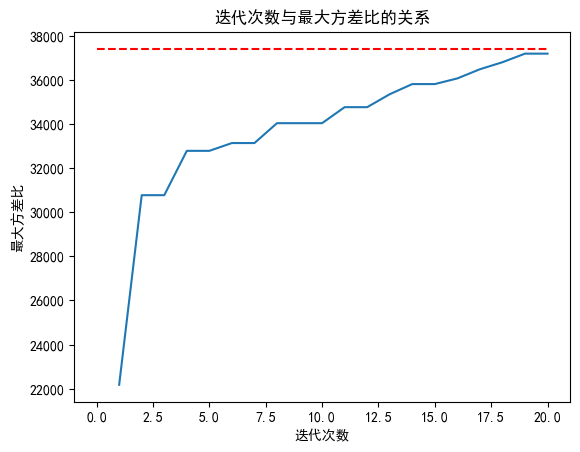

In [80]:
plt.plot(iteration_result[0:20,0],iteration_result[0:20,1])
plt.plot([0,20],[Fitness_Function(cr,131, 179),Fitness_Function(cr,131, 179)],linestyle='--', color='r')
plt.xlabel("迭代次数")
plt.ylabel("最大方差比")
plt.title("迭代次数与最大方差比的关系")

In [37]:
cv2.imshow("skin",skin)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.title("原图")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(dst1,cmap='gray')
plt.axis('off')
plt.title("双阈值分割后")

plt.subplot(1,3,3)
plt.imshow(dst,cmap='gray')
plt.axis('off')
plt.title("改进双阈值分割后")


In [ ]:
# YCrCb_OTSU及其改进算法的作图
skin1 = YCrCb_OTSU(img)
skin2=  YCrCb_OTSU_IMPROVE(img)
fig, axs = plt.subplots(1, 3, figsize=(14,14))          # 创建1X2的网格，其中每个子图大小为14X14 英寸：
plt.subplot(1,3,1)                                      # 占据第一个位置
img_RGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)           # opencv读取的图像是BGR通道的，plt输出时是RGB通道
plt.imshow(img_RGB)
plt.title("原图")                                       # 为第一个子图添加标题

plt.subplot(1,3,2)                                      # 占据第二个位置
plt.imshow(skin1,cmap='Greys_r')                         
plt.title("使用手撸OTSU法阈值分割后")                          

plt.subplot(1,3,3)                                      # 占据第三个位置
plt.imshow(skin2,cmap='Greys_r')                        
plt.title("使用YCrCb+改进OTSU法阈值分割后")


In [ ]:
# 手撸OTSU_IMPROVE实现图像分割
def OTSU_Seg_IMPROVE(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)                             # 若待划分的图像是单通道，则无需转为灰度图
    th = OTSU_IMPROVE(img)[0]
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):     
            if(img[i,j]<th):
                img[i,j]=0
            else:
                img[i,j]=255
    return img 
obj = OTSU_Seg_IMPROVE(img)  
fig, axs = plt.subplots(1, 2, figsize=(14,14))          # 创建1X2的网格，其中每个子图大小为14X14 英寸：
plt.subplot(1,2,1)                                      # 占据第一个位置
img_RGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)           # opencv读取的图像是BGR通道的，plt输出时是RGB通道
plt.imshow(img_RGB)
plt.title("Cameraman.jpg")                                       # 为第一个子图添加标题

plt.subplot(1,2,2)                                      # 占据第二个位置
plt.imshow(obj,cmap='Greys_r')                          # plt默认显示三通道图像
plt.title("使用改进的OTSU法阈值分割后")                              # 为第一个子图添加标题

In [ ]:
# 基于HSV颜色空间H，S，V范围筛选法
def HSV(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # 把图像转换到HSV色域
    (h, s, v) = cv2.split(hsv) # 图像分割, 分别获取h, s, v 通道分量图像
    skin = np.zeros(h.shape, np.uint8)  # 根据源图像的大小创建一个全0的矩阵,用于保存图像数据
    (height, width) = img.shape[0:2] # 获取源图像数据的长和宽

    # 遍历图像, 判断HSV通道的数值, 如果在指定范围中, 则置把新图像的点设为255,否则设为0
    for i in  range(0, height):
        for j in  range(0, width):
            if (h[i][j] >  2) and (h[i][j] <  15) and (s[i][j] >  35) and (s[i][j] <  255) and (v[i][j] >  60) and (v[i][j] <  255):
                skin[i][j] =  255
            else:
                skin[i][j] =  0
    cv2.imshow('skin',skin)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return skin
skin = HSV(img)
# hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # 把图像转换到HSV色域
# cv2.imshow('hsv',hsv)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
#HSV(img)
    


In [ ]:
# 双边滤波
dst1 = cv2.bilateralFilter(img,15,50,50) # 邻域半径为15 sigma_d为空间高斯函数标准差，sigma_r为灰度值相似性高斯函数标准差
cv2.imshow('dst1',dst1)                     # 标准差越大，半径越大，磨皮效果越明显
cv2.waitKey(0)

In [ ]:
# 磨皮算法 
# 通过上述算法获得皮肤区域，遍历双边滤波后的矩阵，将非皮肤区域还原
def skin_buffing(dst1,img,skin1):       #dst1 为双边滤波后的矩阵  img 为原图 skin1 为皮肤区域
    dst2 = dst1.copy()
    for i in range(0,height):   
        for j in range(0,width):
            if(skin1[i,j] == 0):
                dst2[i,j] = img[i,j]

    cv2.imshow('dst2',dst2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return dst2
buffing_bilateral = skin_buffing(dst1,img,skin5)


In [ ]:
# 计算中心范围内像素值方差D(x)
def Calculate_DX(img,x,y,k,size):
    sum = 0
    step = 0
    for i in range(x-size//2,x+size//2+1):
        for j in range(y-size//2,y+size//2+1):
            sum = sum + (int(img[i,j,k]) - int(img[x,y,k]))**2
            print(i,j)
            print((int(img[i,j,k]) - int(img[x,y,k]))**2)
    return sum/(size*size)



In [ ]:

# 设置卷积核大小
kernel_size = (3,3)

# 应用均值滤波
blurred_img = cv2.blur(img, kernel_size)

# 显示原始图像和滤波后的图像
cv2.imshow('Original Image', img)
cv2.imshow('Blurred Image', blurred_img)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# 均值滤波
size = 3
sigma = 5
#def mean_fliter(img,size):
dst = img.copy()           
for i in range(size//2,img.shape[0]-size//2):           #(i,j)为中心位置像素
    for j in range(size//2,img.shape[1]-size//2):
        for k in range(0,2):
            sum = 0
            for m in range(i-size//2,i+size//2+1):
                for n in range(j-size//2,j+size//2+1):
                    sum = sum + img[m,n,k]
            avg = sum/(size*size)
            print('avg='+str(avg))
            DX = Calculate_DX(img,i,j,k,size)
            print('DX='+str(DX))
            K = DX/(DX+sigma)
            print('K='+str(K))
            dst[i,j,k] = img[i,j,k]*K+avg*(1-K)

cv2.imshow('dst',dst)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import cv2
import numpy as np

def guideFilter(I, p, winSize, eps, s):
    # 输入图像的高、宽
    h, w = I.shape[:2]

    # 缩小图像
    size = (int(round(w * s)), int(round(h * s)))
    small_I = cv2.resize(I, size, interpolation=cv2.INTER_CUBIC)
    small_p = cv2.resize(p, size, interpolation=cv2.INTER_CUBIC)

    # 缩小滑动窗口
    X = winSize[0]
    small_winSize = (int(round(X * s)), int(round(X * s)))

    # I的均值平滑 p的均值平滑
    mean_small_I = cv2.blur(small_I, small_winSize)
    mean_small_p = cv2.blur(small_p, small_winSize)

    # I*I和I*p的均值平滑
    mean_small_II = cv2.blur(small_I * small_I, small_winSize)
    mean_small_Ip = cv2.blur(small_I * small_p, small_winSize)

    # 方差、协方差
    var_small_I = mean_small_II - mean_small_I * mean_small_I
    cov_small_Ip = mean_small_Ip - mean_small_I * mean_small_p

    small_a = cov_small_Ip / (var_small_I + eps)
    small_b = mean_small_p - small_a * mean_small_I

    # 对a、b进行均值平滑
    mean_small_a = cv2.blur(small_a, small_winSize)
    mean_small_b = cv2.blur(small_b, small_winSize)

    # 放大
    size1 = (w, h)
    mean_a = cv2.resize(mean_small_a, size1, interpolation=cv2.INTER_LINEAR)
    mean_b = cv2.resize(mean_small_b, size1, interpolation=cv2.INTER_LINEAR)

    q = mean_a * I + mean_b

    return q
    
if __name__ == '__main__':
    eps = 0.01
    winSize = (16,16)       #类似卷积核（数字越大，磨皮效果越好）
    image = cv2.imread("Images/mopi.jpeg")
    #image = cv2.imread('Image/girl1.png')
    #image = cv2.resize(image,None,fx=0.8,fy=0.8,interpolation=cv2.INTER_CUBIC)
    I = image/255.0       #将图像归一化
    p =I
    s = 3 #步长
    guideFilter_img = guideFilter(I, p, winSize, eps,s)

    # 保存导向滤波结果
    guideFilter_img = guideFilter_img  * 255         #(0,1)->(0,255)
    guideFilter_img[guideFilter_img  > 255] = 255    #防止像素溢出
    guideFilter_img = np.round(guideFilter_img )

    guideFilter_img = guideFilter_img.astype(np.uint8)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    input_image = image.astype(np.float32) / 255.0
    guide_image = gray.astype(np.float32) / 255.0

    #guideFilter_img = cv2.ximgproc.guidedFilter(guide_image,input_image,15, 0.01, -1)
    guideFilter_img = (guideFilter_img * 255).astype(np.uint8)
    bilateralFilter_img = cv2.bilateralFilter(image,15,100,100) # 邻域半径为15 sigma_d为空间高斯函数标准差，sigma_r为灰度值相似性高斯函数标准差
    alpha = 0.5
    mix_img = cv2.addWeighted(guideFilter_img,alpha, bilateralFilter_img, 1-alpha, 0)
    
    
    buffing = skin_buffing(mix_img,img,skin5)
    cv2.imshow("image",image)
    cv2.imshow("winSize_16", guideFilter_img )
    cv2.imshow("bilateralFilter_img", bilateralFilter_img)
    cv2.imshow("mix", mix_img )
    
    cv2.imshow("buffing",buffing )
    cv2.imwrite("buffing.png",buffing)
    cv2.waitKey(0)
    cv2.destroyAllWindows()



In [ ]:

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('原图')
plt.axis('off')

plt.subplot(222)
plt.imshow(cv2.cvtColor(guideFilter_img, cv2.COLOR_BGR2RGB))
plt.title('导向滤波')
plt.axis('off')

plt.subplot(223)
plt.imshow(cv2.cvtColor(bilateralFilter_img, cv2.COLOR_BGR2RGB))
plt.title('双边滤波')
plt.axis('off')

plt.subplot(224)
plt.imshow(cv2.cvtColor(mix_img, cv2.COLOR_BGR2RGB))
plt.title('线性叠加后')
plt.axis('off')

